<a href="https://colab.research.google.com/github/vtaranti/Time-Series-Forecasting-with-ARIMA-and-LSTM/blob/master/Time%20Series%20Predictions%20with%20ARIMA%20and%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA and LSTM Time Series Models for Google Trends
### Overview
This project sought to compare Autoregressive Integrated Moving Average (ARIMA) and Long Short-Term Memory (LSTM) models for various time series data. I created generalized functions that could quickly test, iterate, and optimize ARIMA and LSTM models for a given time series input. The general models were used to forecast various trends, including:
- S&P 500 historical data
- "LeBron James" Google Trends
- "Coldbrew" Google Trends
- "Kentucky Derby" Google Trends
- "Gilmore Girls" Google Trends
- "Olympics" Google Trends
- "Zika Virus" Google Trends

I chose these various trends based on their unique shapes to test a variety of seasonality changes, increasing values over time, and sharp disparities. Each section contains a plot of the original data, followed by out-of-sample testing results. 

Further, I included results that used gaussian filtering to smooth the original dataset, followed by modeling of the smoothed dataset. The smoothed modeling results were compared to the original series data to determine whether the filtering improved performance of the models.

### Key Questions Explore
Given a wide range of time series data sets,
- Which model performed better at prediction out-of-sample data: ARIMA or LSTM?
- Does gaussian filtering improve the model results on the original, un-filtered dataset? 

### Key Findings
- The ARIMA model gave lower root mean squared errors (RMSEs) in 5/7 of the studied time series compared to the LSTM model. In many cases, the models gave similar errors, but on the whole, ARIMA provided higher-quality results, though it struggled to converge on a few series.
- Gaussian filtering the dataset prior to creating the model gave lower errors in every case, even when comparing the model results to the original, unfiltered data. On average, the Gaussian filtered predictions reduced the RMSE by close to 100%.


- Average RMSEs for unfiltered data, ARIMA: 21.69 & LSTM: 23.54
- Average RMSEs for Gaussian filtered data, ARIMA: 10.98 & LSTM: 12.22


### Techniques used
- time series analysis and forecasting
- pandas and numpy for datetime, data preparation
- statsmodel and keras for ARIMA and LSTM modeling

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ARIMA Model

The function below creates an ARIMA model rolling forecast for a given input time series. It allows the user to select p, q, and d values, as well as specify whether to log transform (or not). The various steps in the function include:

1. log transforming data
2. creating train/test splits
3. creating an ARIMA model for the train set
4. forecasting the first value in the test set, followed by adding that value to the training set and remodeling, forecasting the next value in the test series, adding that second value to the train set, and so on.
5. inverse transforming the data
6. creating plots and generating error metrics.

This function will be used below with tuning of the p, d, q, and log transform parameters in order to minimize RMSE values for the out-of-sample data associated with various time series.

In [2]:
import matplotlib.dates as mdates

def arima_model(series, data_split, params, future_periods, log):
    
    # log transformation of data if user selects log as true
    if log == True:
        series_dates = series.index
        series = pd.Series(np.log(series), index=series.index)
       
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = []

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=(params[0], params[1], params[2]))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)[0]
    future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
    print('Test RMSE: %.3f' % error)
    
    return predictions, test, future_forecast

# LSTM Neural Network Model

The LSTM calculations use three different functions for creating a dataset that can be modeled, training and testing the LSTM neural network, and then inverting any data transformations so that data can be plotted and error analyzed on the original scale. Each function is described in more detail below.

### Creating the datset

This function is used to create the datsets required for training and testing LSTM neural nets. It accepts a time series, the number of previous periods the user would like to model, the train / test split fractions, and whether to perform differencing or log transforms on the data to make it stationary. It will also scale all data between 0 and 1 for input into the LSTM.

The features to be trained are essentially t-n time periods. So if modeling data for the current month (t-0), the input feature would be the data for the previous month (t-1), while the target would be the actual value for this current month (assuming it's known). Increasing look_back will add additional previous months to include, e.g. two months ago (t-2) and three months ago (t-3).

In [3]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print(df.tail())
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

### Inverse transformations

This inverse transform function simply reverses any transformations performed when generating the dataset. Inversing the transformations allows for the model predictions to be based on the same scale as the original dataset for more intuitive interpretation of results. Both the model creation and inverse transformation functions are automatically called within the LSTM function below.

In [4]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

### LSTM modeling

Calling the LSTM model below only requires a time series dataset, the number of desired look-back periods, the train/test split, whether to log transform or difference the data, and parameters for training such as number of nodes and epochs. Within the function, it creates the train and test datasets—both features and targets—and then trains an LSTM model, followed by forecasting the out-of-sample data. The predictions from the model, as well as the actual target values are then inverse transformed using the function above, and plots are generated along with error metrics.

In [5]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)

    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    
    return train_predict, y_train, test_predict, y_test

# Gaussian Filter Plotting
As shown below with the various examples, Gaussian filtering of the data results in better predictions of out-of-sample data. The function below simply allows for a Gaussian-filtered prediction data series to be compared to the original data series through visualization and RMSE reporting.

In [6]:
def gauss_compare(original_series, predictions, data_split):
    
    # the train/test split used to generate the Gaussian-filtered predictions
    size = int(len(original_series)*data_split)

    # creating a plot of the original series and Gaussian-filtered predictions
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)

    plt.plot(original_series[size:])
    plt.plot(predictions, color='red')
    plt.title('Gauss-Filtered Predictions vs. Original Series')
    plt.show()
    
    # calculating the RMSE between the Gaussian-filtered predictions and original dataset. 
    # the +1 exception code is required when differencing is performed, as the earliest data point can be lost
    try:
        error = np.sqrt(mean_squared_error(predictions, original_series[size:]))
    except:
        error = np.sqrt(mean_squared_error(predictions, original_series[size+1:]))
    print('Test RMSE: %.3f' % error)

# Modeling Various Time Series
The rest of the following code uses the functions above to forecast predictions of various time series. I compared roughly optimized ARIMA models to LSTM models on the unfiltered data for each, as well as with Gaussian filtering. 

The optimization was mostly empirical, with some aid coming from autocorrelation and partial autocorrelation plots for ARIMA parameters (code not shown). In general, I optimized p, d, q and log transformation values for ARIMA models, and log/differencing and epochs for LSTM models. 

For each example, the plots show the out-of-sample predictions with the actual test values, along with RMSE values. For all plots, the actual (or filtered) time series is traced in BLUE, while the predictions are traced in RED. I tried to choose a variety of trends that included seasonality, steep gradients, increases / decreases over time, etc. Hopefully some of the results are interesting.

# S&P 500 historical data

Below shows the S&P 500 historical closing price data from 1950 through October 2017 (obtained through Yahoo Finance). The data is averaged monthly and plotted below. This trend shows increasing values over time, along with some steep increases and decreases. 

The ARIMA model performed slightly better than the LSTM model, but the improvements were mostly negligible. Gaussing filtering the data improved accuracy for both models. A summary of the RMSE values, includes:
- ARIMA RMSE (no filter): 45.50
- LSTM RMSE (no filter): 46.67
- ARIMA RMSE (filtered): 24.57
- LSTM RMSE (filtered): 24.75

In [7]:

!git clone https://github.com/vtaranti/Time-Series-Forecasting-with-ARIMA-and-LSTM.git


fatal: destination path 'Time-Series-Forecasting-with-ARIMA-and-LSTM' already exists and is not an empty directory.


In [8]:
%cd Time-Series-Forecasting-with-ARIMA-and-LSTM

/content/Time-Series-Forecasting-with-ARIMA-and-LSTM


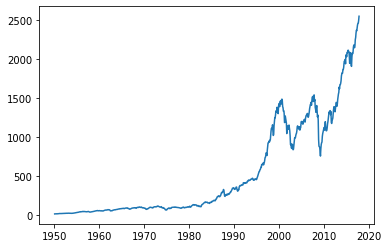

In [9]:
sp500 = pd.read_csv('sphist.csv', parse_dates=['Date'], index_col="Date")
sp500_monthly = sp500.resample('M').mean()
sp500_ts = sp500_monthly.Close
plt.plot(sp500_ts)

### S&P 500 ARIMA model

The ARIMA predictions below have an average RMSE value of 45.5 (with the range of actual values being from ~800 to 2500). One differencing period and log transformation was used.

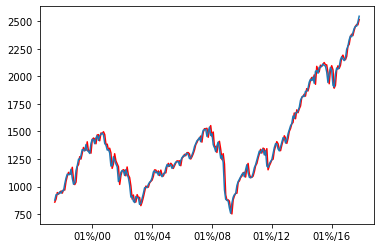

Test RMSE: 45.495


In [10]:
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(sp500_ts, data_split, params, future_periods, log)

### S&P 500 LSTM model

The LSTM model below also uses log transformation and differencing, with 5 training epochs to update model weights. It has a very similar average RMSE error of 46.7.

                 t-0       t-1
Date                          
2017-06-30  0.714528  0.712058
2017-07-31  0.691780  0.714528
2017-08-31  0.670215  0.691780
2017-09-30  0.711003  0.670215
2017-10-31  0.729169  0.711003


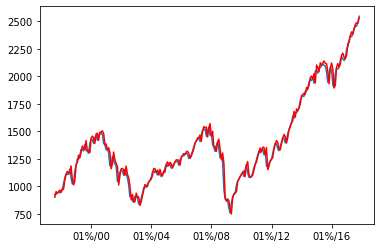

Train RMSE: 6.900
Test RMSE: 47.178


In [11]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(sp500_ts, look_back, split, transforms, lstm_params)

### S&P 500 Gaussian Filtering

Below, I show the same S&P 500 dataset after Gaussian filtering with a sigma value equal to 1. I then trained and tested the model on the filtered dataset, prior to comparing the results to the original data. In both cases (ARIMA and LSTM), the Gaussian filtered results had better error compared to the original dataset. This will end up being the case for every time series studied below.
- ARIMA RMSE (gauss-filtered): 24.57
- LSTM RMSE (gauss-filtered): 24.75

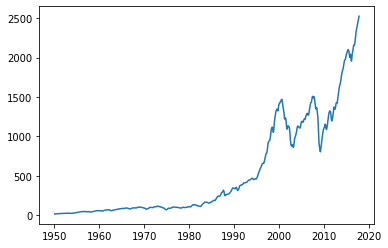

In [12]:
sp500_ts_gauss = pd.Series(gaussian_filter(sp500_ts, sigma=1), index=sp500_ts.index).astype(float)
plt.plot(sp500_ts_gauss)
plt.show()

### Important note about Gaussian results
For each time series below (including this one), there will be two plots for the ARIMA and LSTM models. The top plot will show the predicted and actual values for the Gaussian filtered series. The second plot will show the predictions from the Gaussian-filtered series vs. the actual values from the original, un-filtered series. The RMSE values I use are from the second plot with actual values from the original.

The ARIMA model is shown here, with the LSTM to follow.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


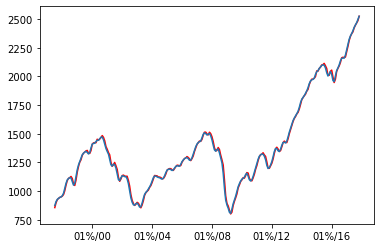

Test RMSE: 15.352


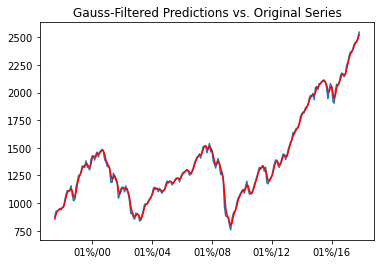

Test RMSE: 24.570


In [13]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(sp500_ts_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(sp500_ts, predictions, data_split)

Again, the LSTM model results will show the filtered predictions and values in the first plot, followed by the filtered predictions and the original, un-filtered values in the second plot.

                 t-0       t-1
Date                          
2017-06-30  0.708340  0.700751
2017-07-31  0.692660  0.708340
2017-08-31  0.687289  0.692660
2017-09-30  0.706337  0.687289
2017-10-31  0.701951  0.706337


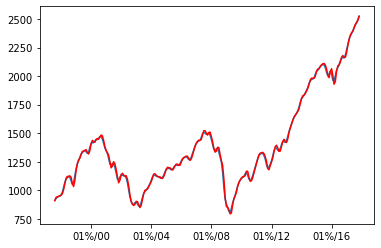

Train RMSE: 2.639
Test RMSE: 16.679


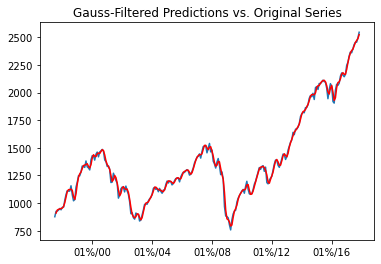

Test RMSE: 25.047


In [14]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(sp500_ts_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(sp500_ts, test_predict, split)

# LeBron James Google Trend

The Google Trend for a "LeBron James" search is shown below. This series was interesting due to the sharp peaks that occur at recurring times. Closer analysis of the peaks shows that the initial spike in 2010 is due to "The Decision" where LeBron changed teams in free agency. Each subsequent spike is during June of each year, the time period when the NBA finals occur. LeBron has made it to 6 consecutive NBA finals, resulting in 6 consecutive spikes.

Out of all the studied series, ARIMA and LSTM had the 2nd most difficulty predicting this trend, likely due to the sharp gradients in the various peaks. ARIMA and Gaussian filtered datasets performed the best. A summary of RMSE results: 
- ARIMA RMSE (no filter): 20.01
- LSTM RMSE (no filter): 27.17
- ARIMA RMSE (filtered): 9.82
- LSTM RMSE (filtered): 13.74

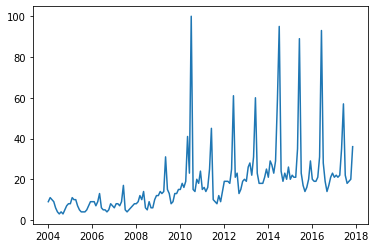

In [15]:
lebron = pd.Series(pd.read_csv('lebron_james.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype(float)
plt.plot(lebron)

### LeBron James ARIMA Model

The ARIMA model had difficulty converging for high values of p and q. It also gave best results with differencing and log transforms.

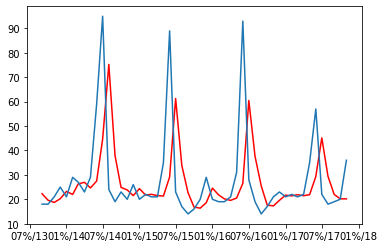

Test RMSE: 20.009


In [16]:
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(lebron, data_split, params, future_periods, log)

### LeBron James LSTM Model

The LSTM results over-predicted the peaks, along with having a time lag before it picked up sharp gradients.

                 t-0       t-1
Month                         
2017-07-01  0.280715  0.708336
2017-08-01  0.503876  0.280715
2017-09-01  0.579538  0.503876
2017-10-01  0.578714  0.579538
2017-11-01  0.738063  0.578714


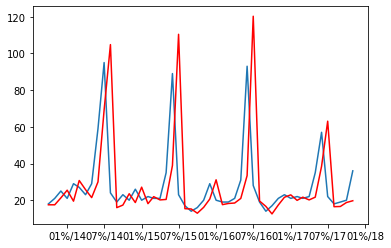

Train RMSE: 17.462
Test RMSE: 25.963


In [17]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(lebron, look_back, split, transforms, lstm_params)

### LeBron James Gaussian Filtering

The dataset with a Gaussian filter and sigma equal to 1 is shown below.

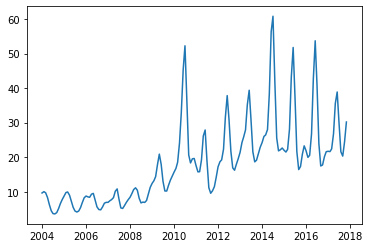

In [18]:
lebron_gauss = pd.Series(gaussian_filter(lebron, sigma=1), index=lebron.index).astype(float)
plt.plot(lebron_gauss)
plt.show()

Comparing ARIMA predictions on the filtered dataset to the original dataset. While the filtered results match the filtered test values very well, the filtered predictions also match up better with the original values. The peak intensities do not reach the same magnitude, but are much more aligned along the time axis.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


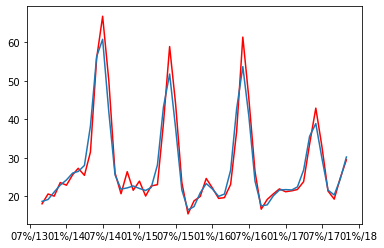

Test RMSE: 3.169


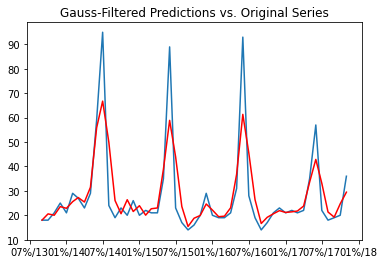

Test RMSE: 9.816


In [19]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(lebron_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(lebron, predictions, data_split)

Comparing LSTM predictions on the filtered dataset to the original dataset. The LSTM predictions improved compared to the unfiltered results, but still show a time lag compared to the filtered, ARIMA results.

                 t-0       t-1
Month                         
2017-07-01  0.294447  0.631607
2017-08-01  0.223928  0.294447
2017-09-01  0.487184  0.223928
2017-10-01  0.723249  0.487184
2017-11-01  0.752657  0.723249


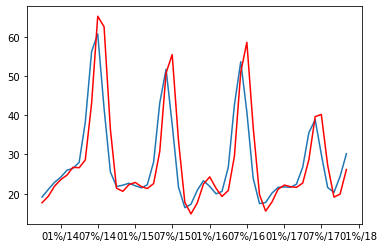

Train RMSE: 3.404
Test RMSE: 7.043


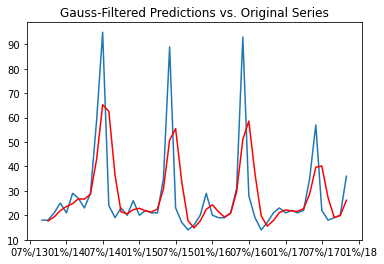

Test RMSE: 14.024


In [20]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(lebron_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(lebron, test_predict, split)

# Cold Brew Google Trend

This section makes predictions based on the Google Trend for "coldbrew", shown below. This series is interesting due to the fluctuations (with peaks occurring in the summer months), as well as its increasing popularity with time. Interestingly, both models performed best (lowest RMSEs) on this dataset. It appears that the smoother gradients of the peaks—occurring over a few months as weather warms and cools—allows the models to more accurately predict the trends.

For this dataset, the LSTM model performed slightly better on the unfiltered data, while the ARIMA performed better on the Gaussian-filtered data. Here is the summary, with details and plots in the following code cells.
- ARIMA RMSE (no filter): 9.16
- LSTM RMSE (no filter): 8.60
- ARIMA RMSE (filtered): 3.03
- LSTM RMSE (filtered): 4.54

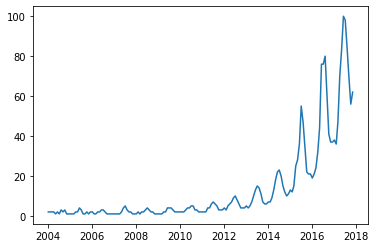

In [21]:
coldbrew = pd.Series(pd.read_csv('coldbrew.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype('float')
plt.plot(coldbrew)

### Coldbrew ARIMA

Overall, the predictions match relatively well for both magnitude, as well as along the time axis.

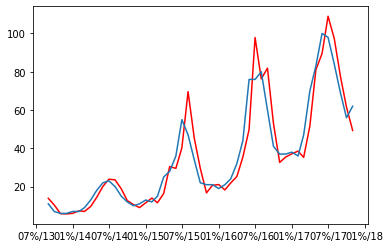

Test RMSE: 9.157


In [22]:
data_split = 0.7
p = 1
d = 1
q = 0
params = [p, d, q]
future_periods = 12
log = False

predictions, test, forecast = arima_model(coldbrew, data_split, params, future_periods, log)

### Coldbrew LSTM

Similar to the ARIMA results, the LSTM predictions match well with the original series and do not overshoot the top of the peaks quite as much.

                 t-0       t-1
Month                         
2017-07-01  0.346154  0.711538
2017-08-01  0.115385  0.346154
2017-09-01  0.096154  0.115385
2017-10-01  0.134615  0.096154
2017-11-01  0.500000  0.134615


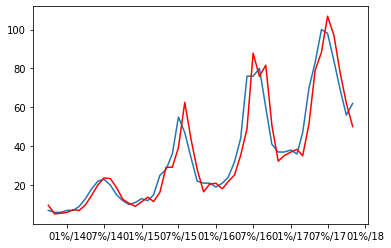

Train RMSE: 1.122
Test RMSE: 8.498


In [23]:
look_back = 1
split = 0.7
log = False
difference = True
transforms = [log, difference]

nodes = 4
epochs = 4
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(coldbrew, look_back, split, transforms, lstm_params)

### Coldbrew Gaussian Filter

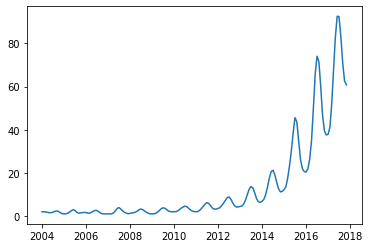

In [24]:
coldbrew_gauss = pd.Series(gaussian_filter(coldbrew, sigma=1), index=coldbrew.index).astype(float)
plt.plot(coldbrew_gauss)
plt.show()

The ARIMA filtered predictions almost perfectly matched the filtered test data. The filtered predictions also matched up well with the unfiltered test data, with almost no time lag or overshooting of the peaks. The smoothe data also allowed for higher p and q values to be used.

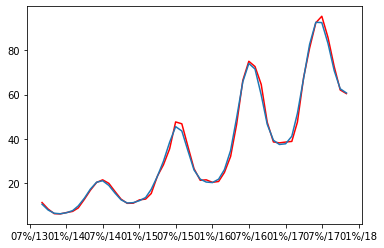

Test RMSE: 1.591


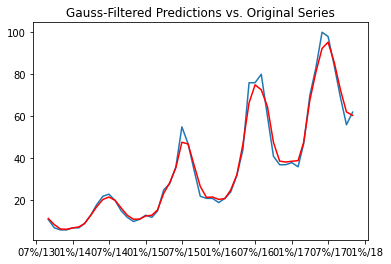

Test RMSE: 3.025


In [25]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(coldbrew_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(coldbrew, predictions, data_split)

The filtered LSTM had a slight time lag on the downward trends, but overall matched well with the original series.

                 t-0       t-1
Month                         
2017-07-01  0.452048  0.576831
2017-08-01  0.336976  0.452048
2017-09-01  0.280309  0.336976
2017-10-01  0.320526  0.280309
2017-11-01  0.420312  0.320526


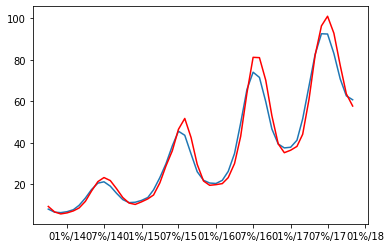

Train RMSE: 0.469
Test RMSE: 4.259


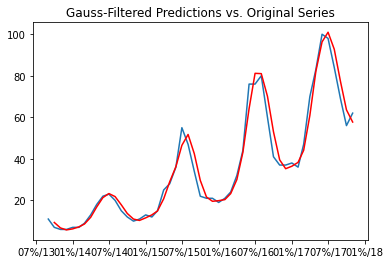

Test RMSE: 4.589


In [26]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(coldbrew_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(coldbrew, test_predict, split)

# Kentucky Derby Google Trend

The Kentucky happens once each year during early May. The periodic sharp trend surrounding the date of the race can be seen in the time series below. I chose this trend to forecast due to its sharp gradients, yet consistent repeating pattern. I wondered if given enough similar training data, whether the models could accurately forecast. 

This dataset ended up having the larget RMSE values out of all modeled timeseries, meaning that despite the repeating pattern, the sharp gradients were still difficult to model. The LSTM performed equally well or slightly better than the ARIMA model, with Gaussian filtering improving error rates by 50%. The ARIMA model also had some difficulty converging for higher p and q values due to the sharp gradients on un-filtered data. A summary of the RMSEs, with plots following in the code below.

- ARIMA RMSE (no filter): 30.94
- LSTM RMSE (no filter): 30.23
- ARIMA RMSE (filtered): 15.23
- LSTM RMSE (filtered): 15.23

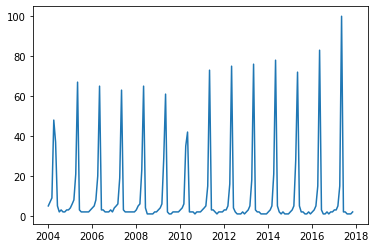

In [27]:
kyderby = pd.Series(pd.read_csv('kentucky_derby.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype('float')
plt.plot(kyderby)

### Kentucky Derby ARIMA model

The ARIMA model struggled to converge due to the sharp gradients. The q=1 value with the differencing (d=1) and log transform was one of the few solutions.

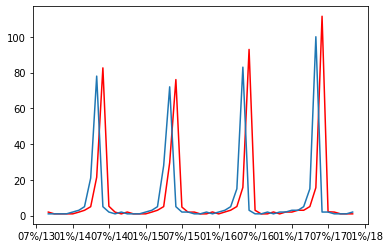

Test RMSE: 30.935


In [28]:
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(kyderby, data_split, params, future_periods, log)

### Kentucky Derby LSTM Model

The LSTM model required very few epochs to train to reasonable accuracy, which may be due to the repeating nature of the series. However, the model had difficulty timing the upward and downard descents of the peak.

                 t-0       t-1
Month                         
2017-07-01  0.673425  0.000000
2017-08-01  0.554105  0.673425
2017-09-01  0.673425  0.554105
2017-10-01  0.673425  0.673425
2017-11-01  0.792745  0.673425


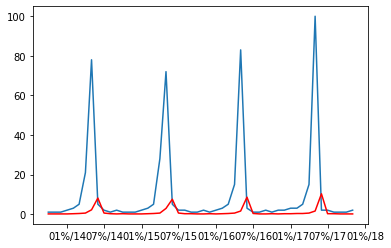

Train RMSE: 19.808
Test RMSE: 23.973


In [29]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 2
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(kyderby, look_back, split, transforms, lstm_params)

### Kentucky Derby Gaussian Filter

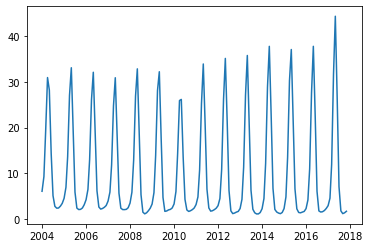

In [30]:
kyderby_gauss = pd.Series(gaussian_filter(kyderby, sigma=1), index=kyderby.index).astype(float)
plt.plot(kyderby_gauss)
plt.show()

Gaussian filtering allowed the ARIMA model to accurately match the slopes of the curves, though as shown in the 2nd plot with the original series, could not reach the same magnitude, and still showed some lag on the downward descents.

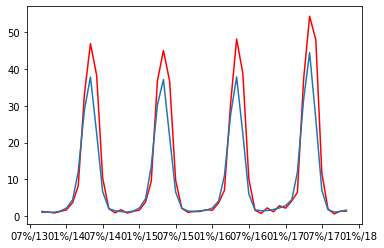

Test RMSE: 5.953


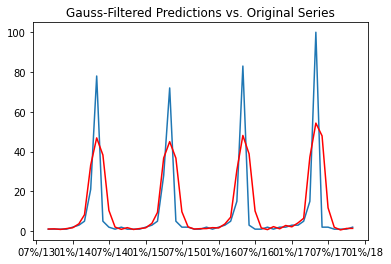

Test RMSE: 15.232


In [31]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 1
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(kyderby_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(kyderby, predictions, data_split)

The LSTM shows similar results to the ARIMA model for the Gaussian filtered data, while actually providing an identical RMSE.

                 t-0       t-1
Month                         
2017-07-01  0.032377  0.359838
2017-08-01  0.000000  0.032377
2017-09-01  0.396289  0.000000
2017-10-01  0.631226  0.396289
2017-11-01  0.669005  0.631226


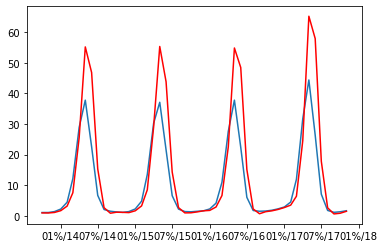

Train RMSE: 7.627
Test RMSE: 9.648


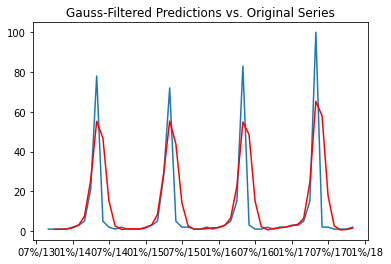

Test RMSE: 15.643


In [32]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 50
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(kyderby_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(kyderby, test_predict, split)

# Gilmore Girls Google Trends

I chose the Gilmore Girls trend below because it has an interesting training and testing split difference. The early years show a lot of popularity associated with the show and its various seasons. The show ended around 2007, but then was brought back by Netflix for a new season almost 10 years later, as shown by the spike during 2017.

While the RMSE values for this series were the second lowest of all studied series, it's likely due to the fact that there is only a single peak for the predictions to fit (or lack thereof). Many of the other series had multiple (3-4), which leads to increased areas. Between the models, ARIMA out-performed LSTM, with Gaussian results better for each. 

Summary error metrics:
- ARIMA RMSE (no filter): 12.03
- LSTM RMSE (no filter): 13.89
- ARIMA RMSE (filtered): 6.52
- LSTM RMSE (filtered): 7.59

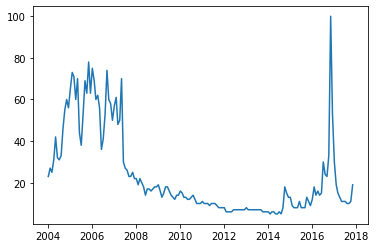

In [33]:
gilmore_girls = pd.Series(pd.read_csv('gilmoregirls.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype(float)
plt.plot(gilmore_girls)

### Gilmore Girls ARIMA model

As mentioned above, the overall error is high comparative to others series, but the time lag seen while predicting the peak shows some difficulty in modeling this data.

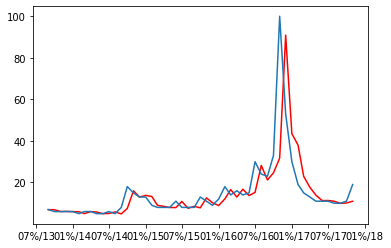

Test RMSE: 12.026


In [34]:
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(gilmore_girls, data_split, params, future_periods, log)

### Gilmore Girls LSTM model

The LSTM model also has trouble timing the peak correctly while also overshooting its magnitude.

                 t-0       t-1
Month                         
2017-07-01  0.412281  0.412281
2017-08-01  0.403509  0.412281
2017-09-01  0.412281  0.403509
2017-10-01  0.421053  0.412281
2017-11-01  0.482456  0.421053


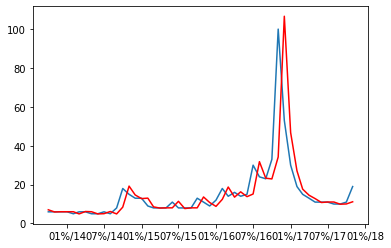

Train RMSE: 7.784
Test RMSE: 12.872


In [35]:
look_back = 1
split = 0.7
log = False
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(gilmore_girls, look_back, split, transforms, lstm_params)

Out of curiosity, I wanted to visualize the training fit. Overall, the ARIMA model performs well on the variations seen 2004-2007.

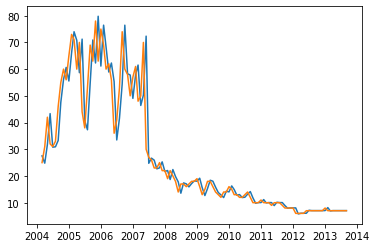

In [36]:
plt.plot(train_predict)
plt.plot(y_train)

### Gilmore Girls Gaussian Filtered

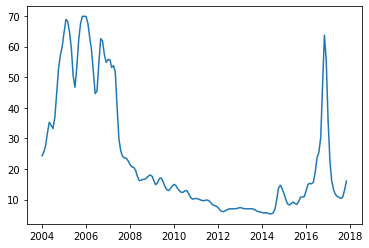

In [37]:
gilmore_girls_gauss = pd.Series(gaussian_filter(gilmore_girls, sigma=1), index=gilmore_girls.index).astype(float)
plt.plot(gilmore_girls_gauss)
plt.show()

The Gaussian filtered results show better accuracy, though the magnitude of the prediction peak is diminished.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/s

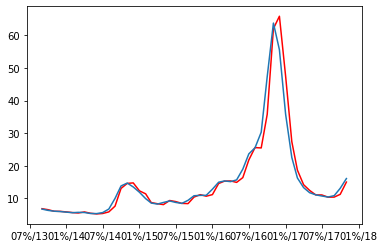

Test RMSE: 3.019


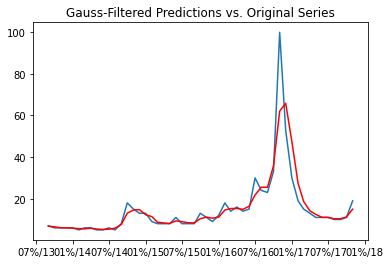

Test RMSE: 6.517


In [38]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(gilmore_girls_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(gilmore_girls, predictions, data_split)

The LSTM model has the peak magnitude more closely matching the original series, but still experiences a time lag on the downward slope.

                 t-0       t-1
Month                         
2017-07-01  0.473413  0.445006
2017-08-01  0.475943  0.473413
2017-09-01  0.553713  0.475943
2017-10-01  0.716193  0.553713
2017-11-01  0.735654  0.716193


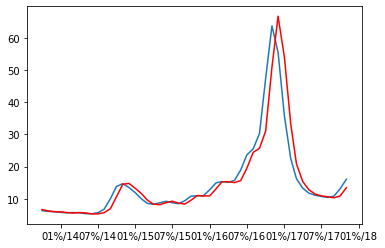

Train RMSE: 2.838
Test RMSE: 4.764


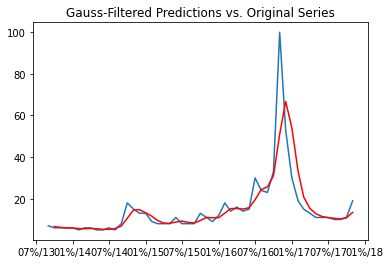

Test RMSE: 8.604


In [39]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(gilmore_girls_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(gilmore_girls, test_predict, split)

# Olympics Google Trend

The Olympics trend, shown below is interesting due to its repeated, yet variable pattern stemming from searches during the Summer Olympics (higher values) followed by searches during the Winter Olympics. In both cases, the peaks are relatively narrow with sharp gradients.

The RMSEs for this trend were close to the median of all the studied time series, but also only showed two peaks as opposed to 4 for higher RMSE trends. ARIMA performed better than the LSTM for both the un-filtered and filtered datasets, as shown below.
- ARIMA RMSE (no filter): 17.42
- LSTM RMSE (no filter): 22.18
- ARIMA RMSE (filtered): 9.15
- LSTM RMSE (filtered): 11.08

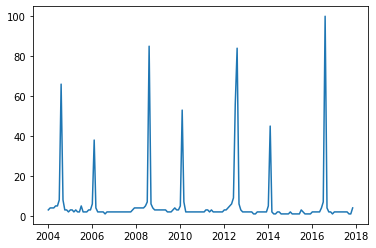

In [40]:
olympics = pd.Series(pd.read_csv('olympics.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype(float)
plt.plot(olympics)

### Olympics ARIMA model

As shown below, both the ARIMA and LSTM struggled to accurately predict the peak magnitude and timing of the peaks.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:51

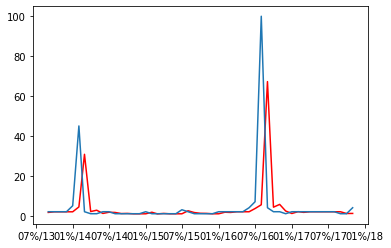

Test RMSE: 17.420


In [41]:
data_split = 0.7
p = 2
d = 2
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(olympics, data_split, params, future_periods, log)

### Olympics LSTM model

                 t-0       t-1
Month                         
2017-07-01  0.507937  0.507937
2017-08-01  0.507937  0.507937
2017-09-01  0.502646  0.507937
2017-10-01  0.507937  0.502646
2017-11-01  0.523810  0.507937


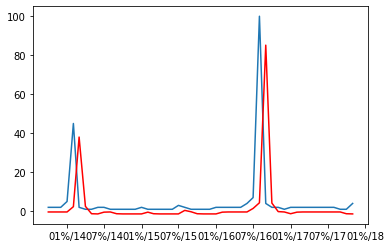

Train RMSE: 16.884
Test RMSE: 19.602


In [42]:
look_back = 1
split = 0.7
log = False
difference = True
transforms = [log, difference]

nodes = 4
epochs = 25
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(olympics, look_back, split, transforms, lstm_params)

### Olympics Gaussian Filtered

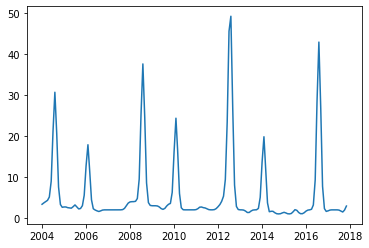

In [43]:
olympics_gauss = pd.Series(gaussian_filter(olympics, sigma=1), index=gilmore_girls.index).astype(float)
plt.plot(olympics_gauss)
plt.show()

Following filtering, the ARIMA model accurately predicts the timing of the peaks, but does not reach the proper magnitude.

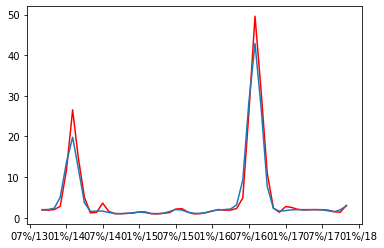

Test RMSE: 1.817


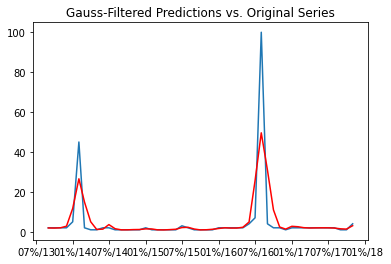

Test RMSE: 9.146


In [44]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 2
d = 1
q = 0
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(olympics_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(olympics, predictions, data_split)

The LSTM model after filtering is closer on magnitude, but has some time lag on the downard slope of the peaks.

                 t-0       t-1
Month                         
2017-07-01  0.515841  0.526468
2017-08-01  0.474162  0.515841
2017-09-01  0.464025  0.474162
2017-10-01  0.645049  0.464025
2017-11-01  0.700858  0.645049


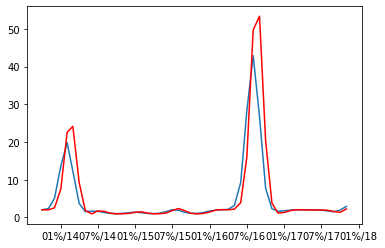

Train RMSE: 4.932
Test RMSE: 5.133


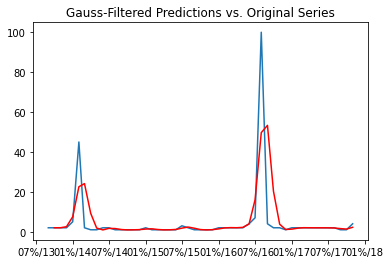

Test RMSE: 11.370


In [45]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(olympics_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(olympics, test_predict, split)

# Zika Virus Google Trend

I chose the Zika Virus trend to see how the algorithms responded to a training series with almost no useful information (constant at 0), followed by a very sharp increase in search interest. 

The ARIMA model performed slightly worse in terms of RMSE, but had a lot of difficulty converging. I was forced to increase the training size to 0.83 in order to capture some movement in the data, i.e. otherwise I received a singular matrix error from all values being constant, results in useless training coefficients.

The LSTM was able to pick up the model trends using the standard 0.7 training size, with slightly better RMSE values in the unfiltered case.
- ARIMA RMSE (no filter): 16.77
- LSTM RMSE (no filter): 16.04
- ARIMA RMSE (filtered): 8.54
- LSTM RMSE (filtered): 8.59

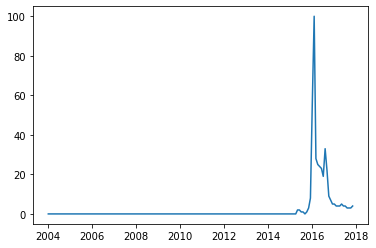

In [46]:
zika = pd.Series(pd.read_csv('zika.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype('float')
plt.plot(zika)

### Zika ARIMA model

The ARIMA model would not converge and gave errors for any training size less than 0.83, giving "singular matrix" errors possibly associated with the constant trend line for the majority of the series. It very roughly models the peak, but has sharp divergences as it tries to capture the shape.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


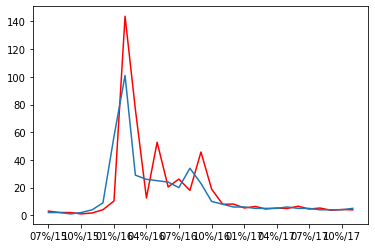

Test RMSE: 16.771


In [47]:
data_split = 0.83
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(zika+1, data_split, params, future_periods, log)

### Zika LSTM model

In this case, the LSTM model performed better and did not have convergence issues.

                 t-0       t-1
Month                         
2017-07-01  0.403350  0.344416
2017-08-01  0.331221  0.403350
2017-09-01  0.403350  0.331221
2017-10-01  0.403350  0.403350
2017-11-01  0.475480  0.403350


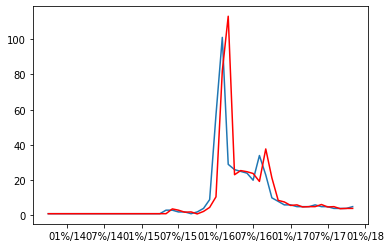

Train RMSE: 0.000
Test RMSE: 14.283


In [48]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(zika+1, look_back, split, transforms, lstm_params)

### Zika Gaussian Filter

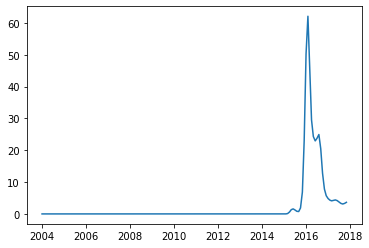

In [49]:
zika_gauss = pd.Series(gaussian_filter(zika, sigma=1), index=zika.index).astype(float)
plt.plot(zika_gauss)
plt.show()

While the ARIMA model performed better with the filtered data (reducing sharp disparities in the predictions), it still could not converge with smaller training set sizes.

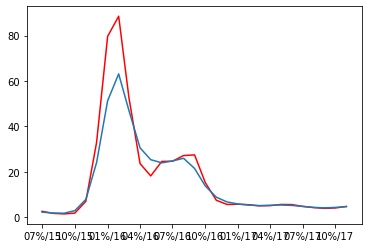

Test RMSE: 7.664


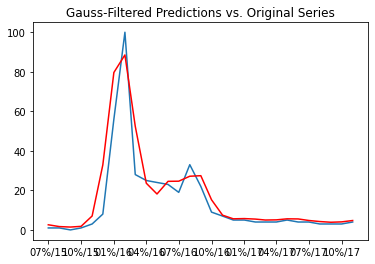

Test RMSE: 8.543


In [50]:
# running ARIMA model with Gaussian Filter
data_split = 0.83
p = 1
d = 2
q = 0
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(zika_gauss+1, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(zika, predictions, data_split)

The LSTM model may have smoothed too much considering the original data, but still performed relatively well in this test.

                 t-0       t-1
Month                         
2017-07-01  0.230133  0.259905
2017-08-01  0.222786  0.230133
2017-09-01  0.256230  0.222786
2017-10-01  0.313202  0.256230
2017-11-01  0.334021  0.313202


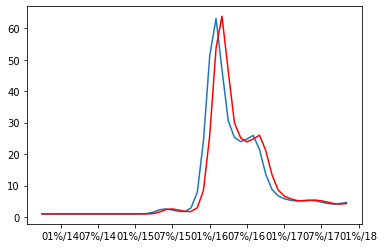

Train RMSE: 0.000
Test RMSE: 5.775


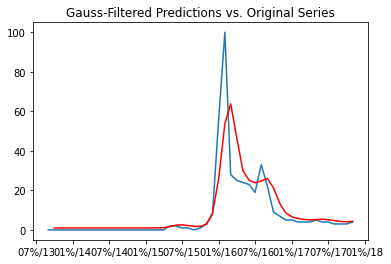

Test RMSE: 10.182


In [51]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(zika_gauss+1, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(zika, test_predict, split)

# Summary

Overall, the results demonstrate that both ARIMA and LSTM are quality algorithms for forecasting time series data. In general, the ARIMA model provided slightly lower errors, but also can suffer from convergence errors for series with sharp gradients. The LSTM series can train and make predictions on any series—though the accuracy must be evaluated.

Further, Gaussian filtering of the dataset improved predictions in every case, even when comparing the filtered predictions to the original, un-filtered dataset. It would be interesting to examine other methods of transformations or filtering (e.g. FFT, wavelet filters) to determine if further gains can be made.